# BLAST XML Parsing and position comparison:



Download your Blast Results as XML file using the highlighted download all dropdown menu


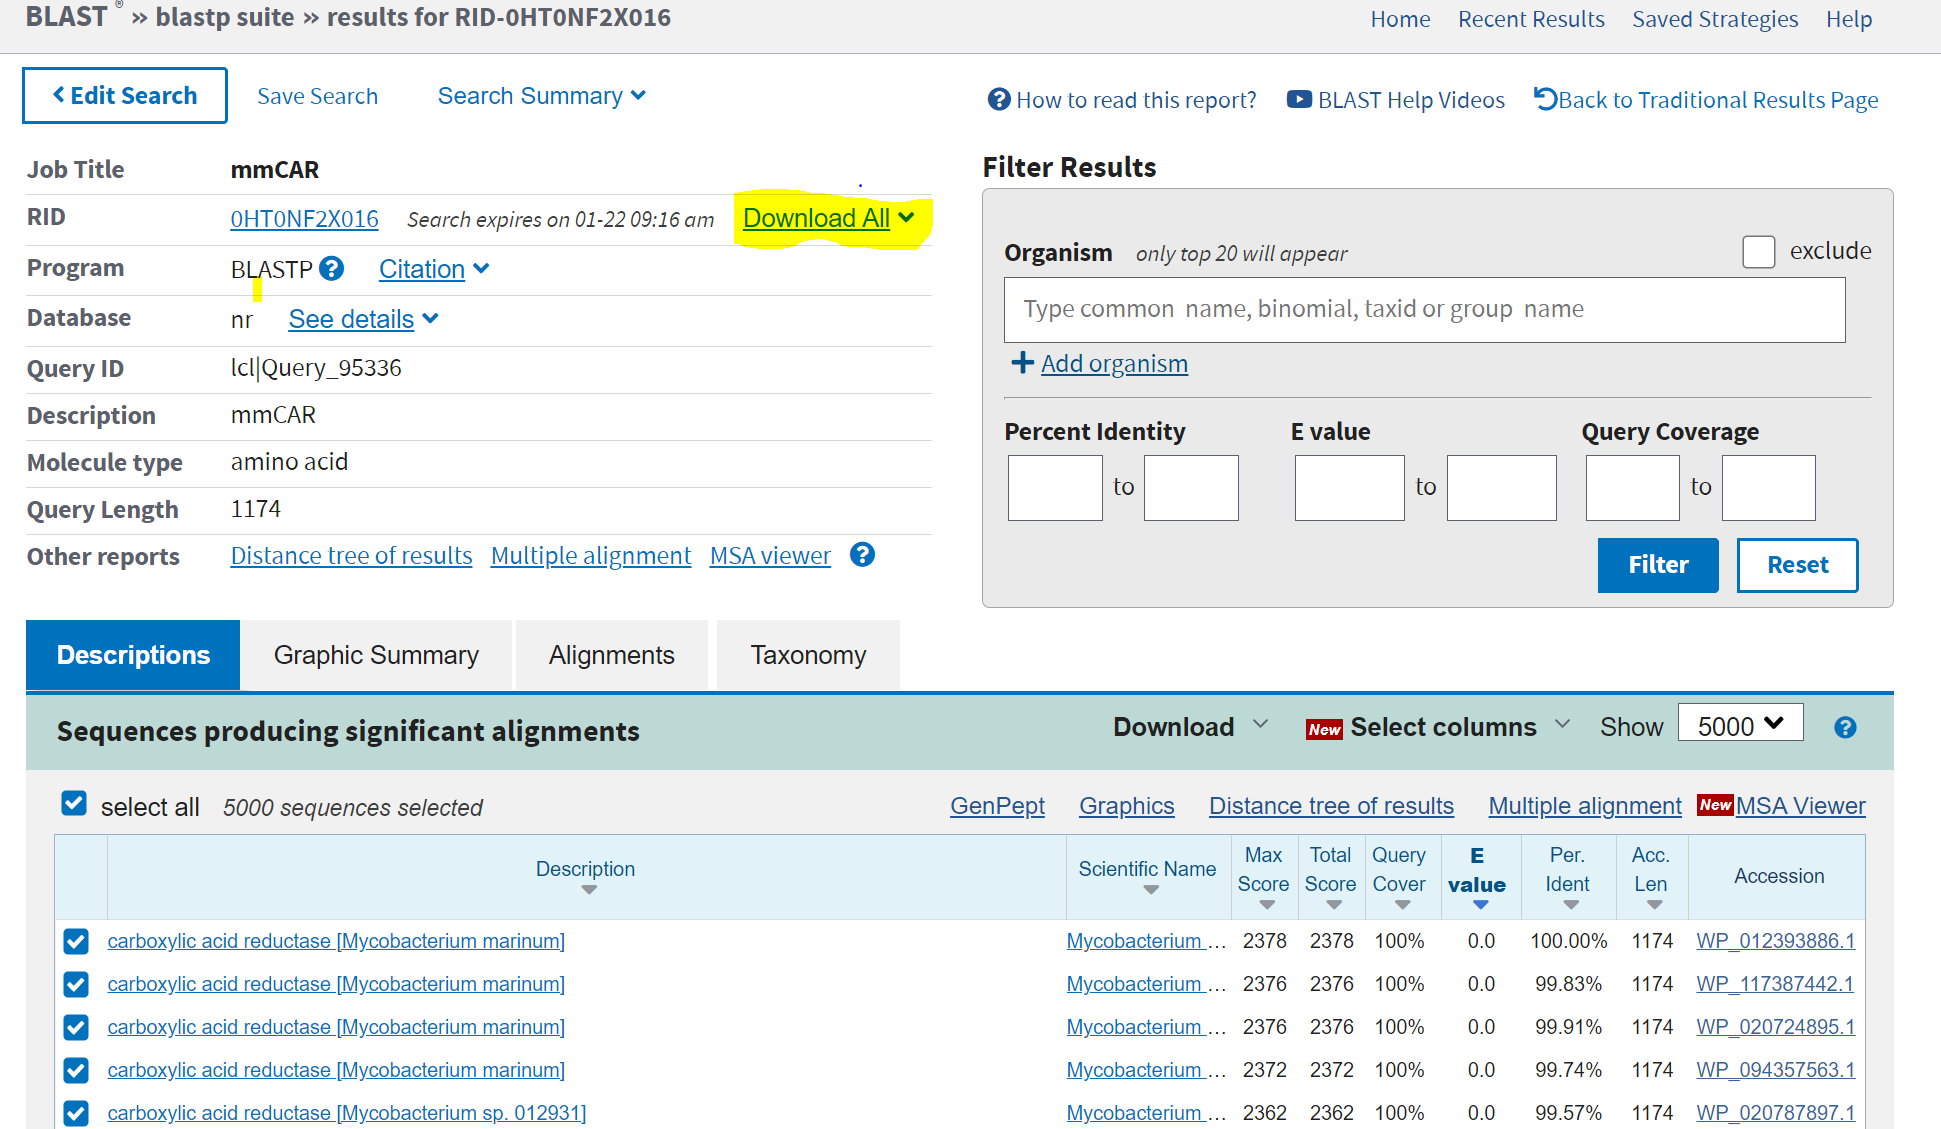

In [ ]:
from Bio.Blast import NCBIXML as xml
import pandas as pd
import collections as c
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez #for getting full sequences from accesions and writing to a single fasta file

This code block handles unpacking of the xml file into blast records that each contain alignments and then storing the information into a single dataframe.

Use an absolute path to the file using double "\\\\" in place of "\\"

In [ ]:
result_handle = open('C:\\Users\\derek\\OneDrive\\Desktop\\UCI\\RESEARCH\\0HT0NF2X016-Alignment.xml')

blast_records = xml.parse(result_handle)

def blast_dataframe(blast_records): 
    diction = {}
    Source_Database = []
    Accessions = []
    Description = []
    length = []
    hsp_qseq = []
    hsp_hseq = []
    hsp_mseq = []
    hsp_score = []
    hsp_query_start = []
    hsp_align_length = []
    hsp_hit_start = []
    hsp_expect = []
    hsp_bits = []
    hsp_identities =[]
    hsp_positives = []
    hsp_query_end = []
    hsp_sbjct_end = []
    hsp_gaps = []
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            rawtitle = alignment.title
            parts = rawtitle.strip().split('|')
            Source_Database.append( parts[0] )
            Accessions.append( parts[1] )
            Description.append( parts[2])
            length.append( alignment.length)
            for h,hsp in enumerate(alignment.hsps):
                #print(hsp)
                #print(h)
                if h >= 1:  #Very important this removes worse alignments from the same gene, multiple alignments per gene will cause there to be too many alignments to pair with genes (array error)
                    break
                hsp_qseq.append(hsp.query)
                hsp_hseq.append(hsp.sbjct)
                hsp_mseq.append(hsp.match)
                hsp_score.append(hsp.score)
                hsp_query_start.append(hsp.query_start)
                hsp_align_length.append(hsp.align_length)
                hsp_hit_start.append(hsp.sbjct_start)
                hsp_expect.append(hsp.expect)
                hsp_bits.append(hsp.bits)
                hsp_identities.append(hsp.identities)
                hsp_positives.append(hsp.positives)
                hsp_query_end.append(hsp.query_end)
                hsp_sbjct_end.append(hsp.sbjct_end)
                hsp_gaps.append(hsp.gaps)
    diction =    {'Source_Database' : Source_Database,
                  'Accessions' : Accessions,
                  'Description' : Description,
                  'length': length,
                  'hsp_qseq' : hsp_qseq, 
                  'hsp_hseq' : hsp_hseq,
                  'hsp_mseq' : hsp_mseq,
                  'hsp_score' : hsp_score,
                  'hsp_query_start' : hsp_query_start,
                  'hsp_align_length' :hsp_align_length,
                  'hsp_hit_start' : hsp_hit_start,
                  'hsp_expect': hsp_expect,
                  'hsp_bits' : hsp_bits,
                  'hsp_identities' : hsp_identities,
                  'hsp_positives' : hsp_positives,
                  'hsp_query_end' : hsp_query_end,
                  'hsp_sbjct_end' : hsp_sbjct_end,
                  'hsp_gaps' : hsp_gaps
                 } 
    keys = [key for key in diction]
    df = pd.DataFrame(diction,columns = keys) 
    return df.set_index('Accessions')
df1 = blast_dataframe(blast_records)
result_handle.close()
df1
#df1 = df1.iloc[0:2000]

In [ ]:

def add_to_df_and_plot(orig_dataframe, dictionary_of_matches_,collabel,dom_q):
    lis = list(dictionary_of_matches_.keys())
    df_ = orig_dataframe.loc[lis,:]
    df_[collabel] = pd.Series(dictionary_of_matches_)
    df_[collabel+'_query'] = pd.Series(dom_q)
    Hit_res_ = list(df_[collabel])
    Hit_res_count = c.Counter(Hit_res_)
    Sum = sum(Hit_res_count.values())
    percentfreqs = {}
    for key in Hit_res_count:
        percentfreqs[key] = (Hit_res_count[key] / Sum)
    Hit_res_count.values
    print(Hit_res_count)
    y_pos = np.arange(len(percentfreqs))
    fig = plt.figure()
    plt.bar(y_pos,percentfreqs.values(), align='center', alpha=1, color = ['#A5A5A5','#FFC000','#5B9BD5','#9751CB','#ED7D31','#70AD47'])
    plt.xticks(y_pos, percentfreqs.keys())
    plt.ylabel('Freq')
    plt.title('Frequency of sequences with {}'.format(collabel))
    plt.show()
    return df_

In [ ]:
def dict_append_to_df(orig_dataframe, dictionary,Column_label):
    lis = list(dictionary.keys())
    df_ = orig_dataframe.loc[lis,:]
    df_[Column_label] = pd.Series(dictionary)
    return df_


In [ ]:

def intersector(list_of_dictionary):
    intersect = set(list_of_dictionary[0].keys())
    for _dict in list_of_dictionary:
        intersect = intersect & set(_dict.keys())
    return intersect


This function determines what position in the alignment to look at.  There is a known bug with very heavily gapped and truncated alignments sometimes not finding the exact position, these genes and the base found instead are listed in the error dictionary output.

In [ ]:
def get_position(df, posi,Expected_WT_Residue):
    print('the length of the blast dataframe is: ' + str(len(df)))
    output= {}
    output2 = {}
    error = {}
    gaploc= {}
    hseq = df['hsp_hseq']
    qseq = df['hsp_qseq']
    qi = df['hsp_query_start']
    for number,gene in enumerate(hseq.index):
        gaploc[gene] = [n for n in range(len(qseq[gene])) if qseq[gene].find('-', n) == n]
        shift = 0
        pos = int(posi)
        h = hseq[gene]
        q = qseq[gene]
        qindex = int(qi[gene])
        for gap in gaploc[gene]:
            if ((pos - qindex + shift) > (gap)):
                shift +=1   
        q_pos = pos - qindex + shift
        if  len(q) > q_pos and q_pos > 0:
            if Expected_WT_Residue == q[q_pos]:
                output[gene] = h[q_pos]
                output2[gene] = q[q_pos]
            else:
                print('Gap Error: '+gene[0:100]+'\nwas not included in dataframe because the position requested was not at expected index\n Please check this sequence manually\n')
                error[gene] = q[q_pos]
        elif (q_pos < 0):
            print('Residue {} outside alignment for gene: \n{}'.format(pos,gene))
            
    return output, output2, error

This line unpacks the function output tuple into three variables.

Arguments(dataframe from xml parser, which position to look at in query sequence, 1-indexed (query is the sequence you input into blast), WT Residue one-letter amino acid code)

In [ ]:
%%time
(dict_get_pos,dict_get_pos2,error) = get_position(df1, 788, 'G')


This Line runs the append and plotfunction, the next line selects only the hits that are not equal to the listed Base.

Arg(dataframe from xmlparser, dictionary of gene:hit sequence at a given position, Title of appended column name, dictionary of gene:query sequence at a given position

In [ ]:
df200_all = add_to_df_and_plot(df1, dict_get_pos,'Residue_787',dict_get_pos2)
aaa = df200_all[(df200_all['Residue_787'] != 'G')]
aaa

This function appends the Percent Identity as a column to a given dataframe.

Calculated as 100* #matching identity residues / (length of the aligned query sequence)

In [ ]:
def append_percent_id(dataframe):
    x = (100*dataframe.loc[:,'hsp_identities'] / (dataframe.loc[:,'hsp_query_end']-dataframe.loc[:,'hsp_query_start']))
    dataframe = dataframe.assign(Percent_Identitity = x)
    return dataframe

#aaaa = append_percent_id(error)
aaaa

Save a dataframe to Csv file:

In [ ]:
#aaa.to_csv('tester.csv')

In [ ]:
def df_append_accesions(dataframe):
    genes = list(dataframe.index)
    accessions = {}
    for gene in genes:
        genesplit = gene.split('|')
        accessions[gene] = genesplit[1] #the 0 is the database code (ref,gb,emd), 1 is the accession
    dataframe.loc[:,'Accessions'] = pd.Series(accessions) 
    return dataframe   
#df_acc = df_append_accesions(aaa)
#df_acc

# How to get a file containing all the complete protein sequences as a Fasta file quickly

Use the Fasta file writing function below for a dataframe that contains accession numbers column 

Only works for one database at a time. gb, emb or ref

The second option is better if you don't run large dataframes multiple times.

In [ ]:
def exportAccessions(dataframe, filename):
    dataframe['Accessions'].to_csv(filename)
    print('Accessions printed, remove the column header "Accession" and index column in MS excel then proceed to\n https://www.ncbi.nlm.nih.gov/sites/batchentrez to generate FASTA\n Once the file has been uploaded use the send to button in upper right to send all sequences to a single fasta file')
    return

#exportAccessions(df_acc,'acces.csv')
    

# Entrez NCBI Database lookup, email must be provided to warn you if you excessively use the webserver bandwidth

This option works for mixed data base results can fetch sequences from gb, emb, and ref

In [ ]:
%%time
def writeAccessionsFasta(dataframe,filename): #requires import of Entrez from Bio module
    Entrez.email = 'daspacio@uci.edu' #You will get an email if you excessively use the Entrez webserver for NCBI database lookups
    handle = Entrez.efetch(db="protein", id= dataframe.index, rettype="fasta", retmode="text")
    fasta = open(filename, "w")
    print('writing accessions to '+ filename + '...')
    for line in handle:
        fasta.write(line)
    fasta.close()
    print('file write completed')
    return
#writeAccessionsFasta(your_dataframe_with_accession_as_index,'My_Fasta.fasta')